In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter

import sys
sys.path.append('../visualization')
sys.path.append('../acd/util')
sys.path.append('../acd/scores')
sys.path.append('../acd/agglomeration')
import agg_2d as agg
import viz_2d as viz
import tiling_2d as tiling
import cd
import score_funcs
plt.style.use('dark_background')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the model and dset

In [9]:
# load the dataset
sys.path.append('../dsets/mnist')
import dset
from model import Net
im_torch, im_orig, label = dset.get_im_and_label(250, device=device) # this will download the mnist dataset


# load the model
model = Net().to(device)
model.load_state_dict(torch.load('../dsets/mnist/mnist.model', map_location=device))
model = model.eval()

# generate different amounts of blur

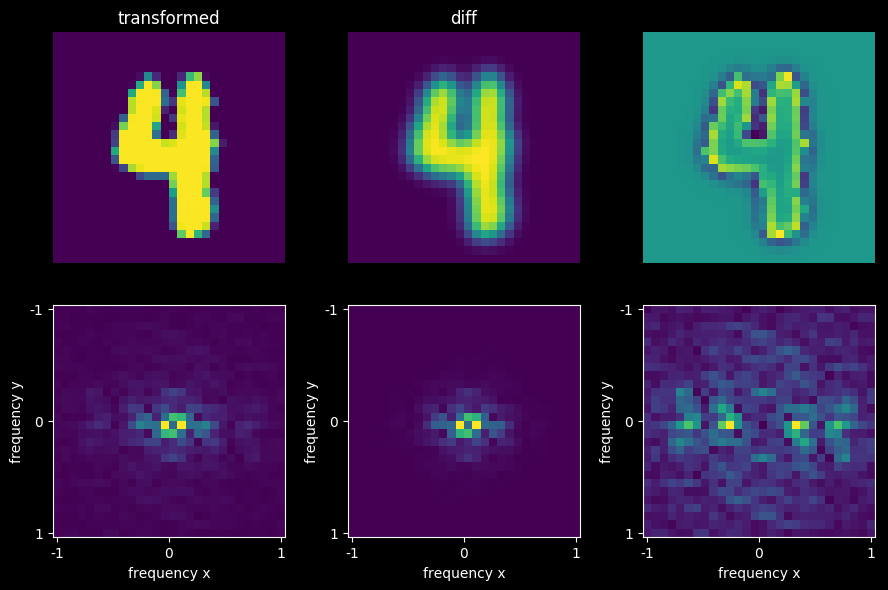

In [142]:
def visualize(im_orig, transform):
    plt.figure(dpi=100, figsize=(9, 6))
    R, C = 2, 3
    tits = ['orig', 'transformed', 'diff']
    ims = [im_orig, transform(im_orig), im_orig - transform(im_orig)]
    for i in range(3):    
        plt.title(tits[i])
        plt.subplot(R, C, i + 1)
        plt.imshow(ims[i])
        plt.axis('off')
    
    for i in range(3):
        plt.subplot(R, C, 4 + i)
        plt.imshow(np.fft.fftshift(np.abs(np.fft.fft2(ims[i]))))
        plt.xticks([0, 13.5, 27], labels=[-1, 0, 1])
        plt.yticks([0, 13.5, 27], labels=[-1, 0, 1])
        plt.xlabel('frequency x')
        plt.ylabel('frequency y')

    plt.tight_layout()
    

visualize(im_orig, transform)

In [138]:
class Transforms:
    def __init__(self):
        self.sigma = 1
    def gaussian_filter(self, x): 
        '''Filter with given sigma
        '''
        if 'Tensor' in str(type(x)):
            x = x.cpu().numpy().squeeze()
            return torch.Tensor(gaussian_filter(x, sigma=self.sigma)).reshape(1, 1, 28 , 28)
        return gaussian_filter(x, sigma=self.sigma)
    def bandpass_filter(self, x, delta=0.1): 
        '''Filter with given sigma within freq band of plus or minus 0.1
        '''
        if 'Tensor' in str(type(x)):
            x = x.cpu().numpy().squeeze()
            lower_freqs = gaussian_filter(x, sigma=self.sigma+delta)
            higher_freqs = gaussian_filter(x, sigma=self.sigma-delta)
            out = higher_freqs - lower_freqs
            return torch.Tensor(out).reshape(1, 1, 28 , 28)
        return gaussian_filter(x, sigma=self.sigma)
t = Transforms()

**score monotonically decreases as we lose higher frequencies, cool!**

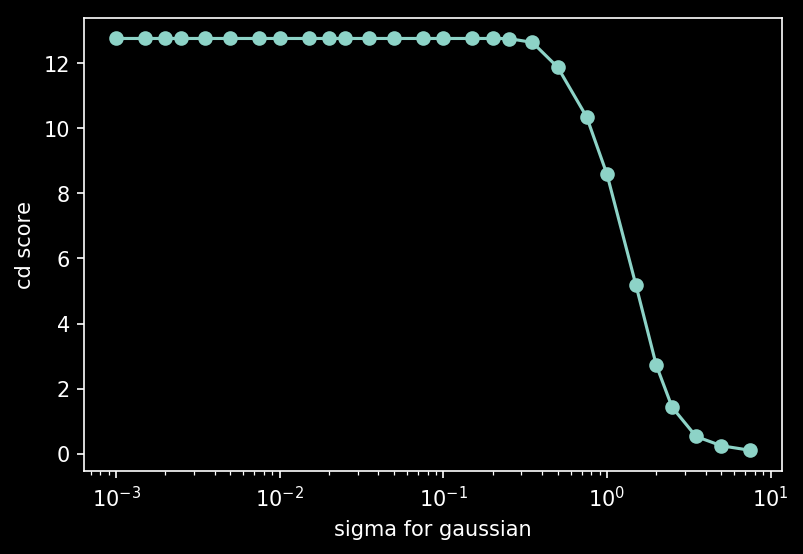

In [134]:
class_num = 4
scores = []
nums = np.array([1, 1.5, 2, 2.5, 3.5, 5, 7.5])
sigmas = list(nums * 1e-3) + list(nums * 1e-2) + list(nums * 1e-1) + list(nums * 1e0)
for sigma in sigmas:
    t.sigma = sigma
    score = cd.cd(im_torch, model, mask=None, model_type='mnist', 
          device='cuda', transform=t.gaussian_filter)[0].flatten()[class_num].item()
    scores.append(score)
    
# plot
plt.figure(dpi=150)
plt.plot(sigmas, scores, 'o-')
plt.xlabel('sigma for gaussian')
plt.xscale('log')
plt.ylabel('cd score')
plt.show()    

**important freqs are around sigma=1**

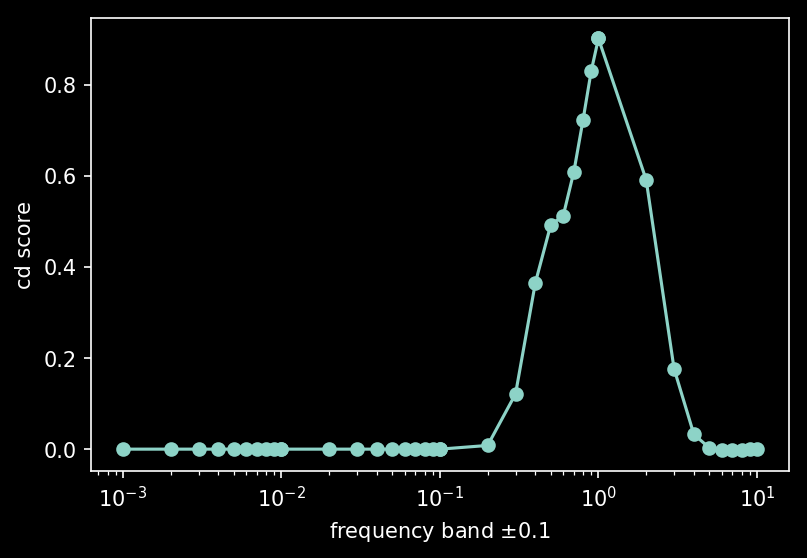

In [139]:
class_num = 4
scores = []
nums = np.linspace(1, 10, 10) #np.array([1, 1.5, 2, 2.5, 3.5, 5, 7.5])
sigmas = list(nums * 1e-3) + list(nums * 1e-2) + list(nums * 1e-1) + list(nums * 1e0)
for sigma in sigmas:
    t.sigma = sigma
    score = cd.cd(im_torch, model, mask=None, model_type='mnist', 
          device='cuda', transform=t.bandpass_filter)[0].flatten()[class_num].item()
    scores.append(score)
    
# plot
plt.figure(dpi=150)
plt.plot(sigmas, scores, 'o-')
plt.xlabel('frequency band $\pm 0.1$')
plt.xscale('log')
plt.ylabel('cd score')
plt.show()    

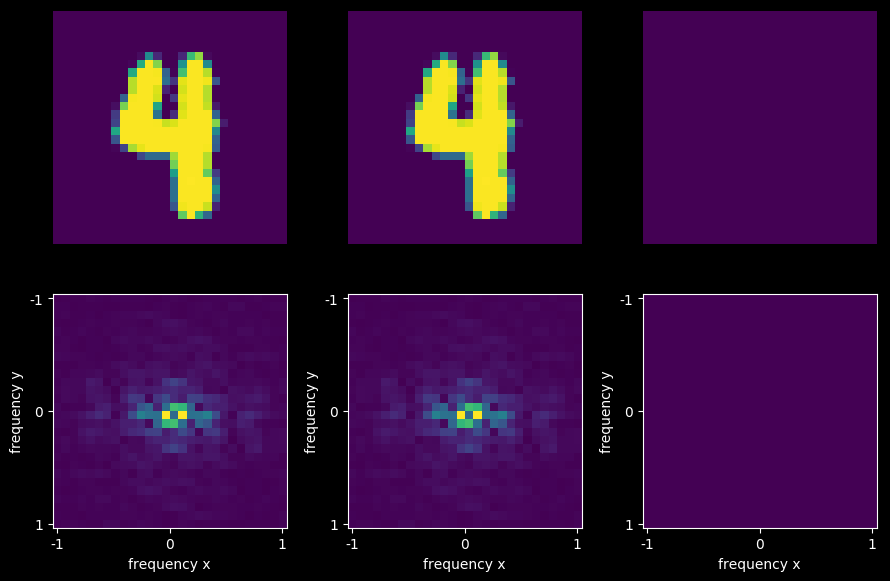

In [140]:
t.sigma = 1e-3
transform = t.bandpass_filter
visualize(im_orig, transform)

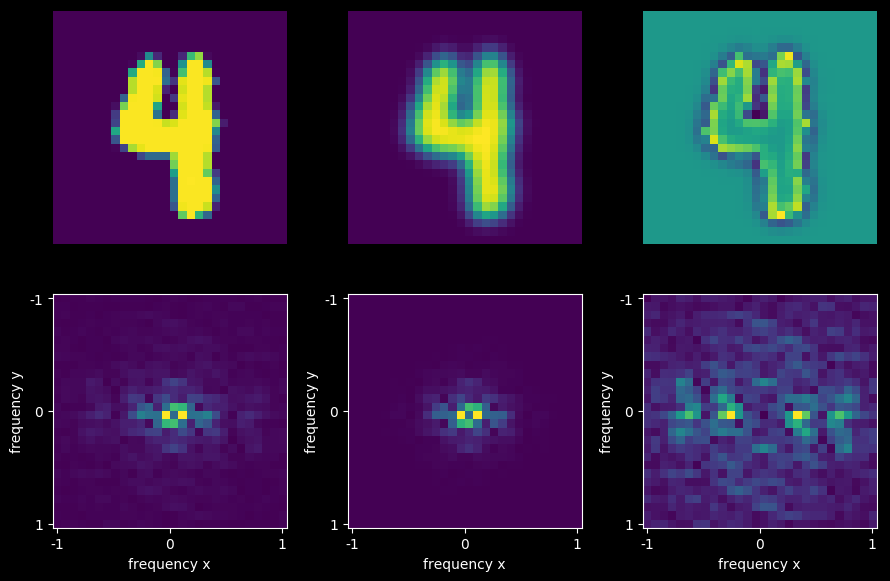

In [141]:
t.sigma = 1e0
transform = t.bandpass_filter
visualize(im_orig, transform)